## XGrid Theft Detector - Binary Classification with XGBoost - Part 1

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier


In [2]:
# The original State Grid Corporation of China (SGCC) dataset used for training models in this project 
# contains 42,372 rows and 1,036 columns. It was utilized for extensive data cleaning and 
# feature selection to train the XGBoost model.

# Due to its large size (~163 MB), it cannot be hosted directly on GitHub, 
# but it is available on Kaggle: https://www.kaggle.com/datasets/bensalem14/sgcc-dataset

# For demonstration and preview purposes, refer to `xgrid-theft-detector-small-dataset.ipynb` located in the `/data/raw` directory.

# Load the dataset
data = pd.read_csv('../data/raw/dataset.csv')
data.head()


,1/1/2014,1/2/2014,1/3/2014,1/4/2014,1/5/2014,1/6/2014,1/7/2014,1/8/2014,1/9/2014,1/10/2014,...,10/24/2016,10/25/2016,10/26/2016,10/27/2016,10/28/2016,10/29/2016,10/30/2016,10/31/2016,CONS_NO,FLAG
0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25,0387DD8A07E07FDA6271170F86AD9151,1
1,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,17.13,14.32,16.37,26.33,19.06,17.38,13.94,14.14,01D6177B5D4FFE0CABA9EF17DAFC2B84,1
2,0.0,0.0,0.00,0.0,0.0,4.98,9.87,11.29,13.44,11.34,...,NaN,1.43,2.22,2.41,3.48,2.89,1.88,1.16,4B75AC4F2D8434CFF62DB64D0BB43103,1
3,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,20.98,18.47,15.50,14.80,19.28,16.10,17.51,16.67,B32AC8CC6D5D805AC053557AB05F5343,1
4,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.61,1.33,0.55,1.62,1.53,2.10,1.16,2.13,EDFC78B07BA2908B3395C4EB2304665E,1


In [3]:
data.shape

(42372, 1036)

## Exploratory Data Analysis - EDA

In [4]:
# I will drop the CONS_NO column since it seems to provide no information as well as being of string type
data = data.drop("CONS_NO", axis=1)

In [5]:

# Check summary statistics
summary_stats = data.describe()
summary_stats


,1/1/2014,1/2/2014,1/3/2014,1/4/2014,1/5/2014,1/6/2014,1/7/2014,1/8/2014,1/9/2014,1/10/2014,...,10/23/2016,10/24/2016,10/25/2016,10/26/2016,10/27/2016,10/28/2016,10/29/2016,10/30/2016,10/31/2016,FLAG
count,25870.000000,25873.000000,25872.000000,25874.000000,25874.000000,25878.000000,25879.000000,25907.000000,25907.000000,25912.000000,...,41824.000000,41820.000000,41665.000000,41623.000000,41397.000000,41443.000000,41637.000000,41634.000000,41569.000000,42372.000000
mean,7.168735,7.057237,6.704972,7.237638,7.394550,6.939544,7.271432,6.862706,6.956579,6.954202,...,9.692272,8.503682,9.032455,9.396710,9.878270,9.934374,8.845107,8.355138,8.224294,0.085316
std,34.131237,30.086443,31.223720,49.508191,41.464202,37.583286,64.114745,34.842458,39.684055,40.017856,...,75.590148,81.278000,79.378526,80.896258,92.312243,88.382736,84.201505,78.702362,70.861576,0.279354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.810000,0.750000,0.790000,0.810000,0.840000,0.870000,0.790000,0.770000,0.770000,0.000000
50%,3.310000,3.400000,3.110000,3.340000,3.560000,3.325000,3.120000,3.210000,3.120000,2.870000,...,4.780000,4.290000,4.420000,4.530000,4.650000,4.710000,4.450000,4.390000,4.290000,0.000000
75%,8.910000,8.570000,8.110000,8.320000,8.880000,8.290000,8.090000,8.120000,8.210000,8.170000,...,9.662500,8.400000,8.680000,9.010000,9.350000,9.510000,8.750000,8.490000,8.110000,0.000000
max,3318.000000,2500.000000,2674.000000,5670.000000,4854.000000,4170.000000,7119.810000,3546.000000,4416.000000,3966.000000,...,11100.000000,13560.000000,11940.000000,12480.000000,15180.000000,14970.000000,14100.000000,12480.000000,9990.000000,1.000000


In [6]:
# by row
df=data.drop('FLAG',axis=1)
df=df.apply(pd.DataFrame.describe, axis=1)
df['FLAG']=data['FLAG']
df

,count,mean,std,min,25%,50%,75%,max,FLAG
0,1030.0,0.947796,3.101514,0.00,0.0000,0.000,0.0000,18.29,1
1,846.0,4.606312,7.107997,0.00,0.4100,0.955,5.3875,44.57,1
2,714.0,8.312549,10.289867,0.00,1.3700,5.070,11.5500,79.71,1
3,1017.0,3.638446,7.999479,0.00,0.0000,0.000,0.0000,40.98,1
4,355.0,67.649718,64.411585,0.00,9.7400,52.440,101.8000,399.40,1
...,...,...,...,...,...,...,...,...,...
42367,853.0,7.054314,3.361116,0.00,4.4800,6.850,9.2300,18.53,0
42368,908.0,9.914218,3.897903,0.00,6.9600,9.525,12.6975,19.69,0
42369,796.0,1.372349,1.011657,0.00,0.6275,1.210,1.9600,4.81,0
42370,801.0,4.147203,1.583176,0.36,3.3700,4.260,5.1200,11.34,0


In [7]:
# Check the number of instances of each class
class_counts = data['FLAG'].value_counts()
class_counts

FLAG
0    38757
1     3615
Name: count, dtype: int64

Text(0.5, 1.0, 'FLAG Imbalanced Distribution')

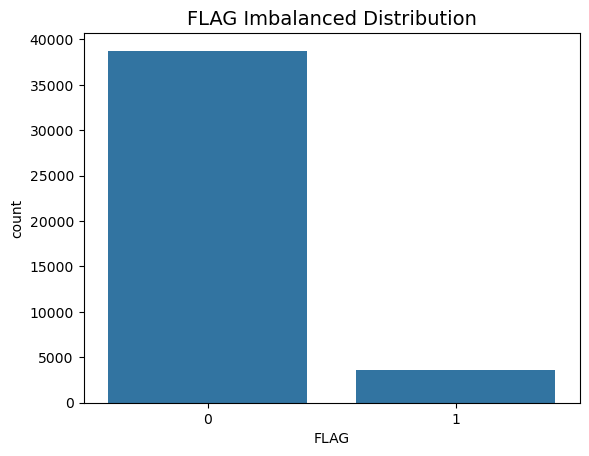

In [8]:
sns.countplot(x=data['FLAG'])
plt.title('FLAG Imbalanced Distribution', fontsize=14)

In [9]:
# Get the number of missing values and percentage
missing_percentage = (data.isna().sum() / len(data)) * 100
print(missing_percentage)
# Assuming your DataFrame is named "data"
missing_values = data.isna().sum()

# To get the total number of missing values in the entire DataFrame
total_missing_values = missing_values.sum()

print("Missing values per column:")
print([x for x in missing_values if x!=0])
print("Total missing values in the DataFrame:", total_missing_values)

1/1/2014      38.945530
1/2/2014      38.938450
1/3/2014      38.940810
1/4/2014      38.936090
1/5/2014      38.936090
                ...    
10/28/2016     2.192486
10/29/2016     1.734636
10/30/2016     1.741716
10/31/2016     1.895119
FLAG           0.000000
Length: 1035, dtype: float64
Missing values per column:
[16502, 16499, 16500, 16498, 16498, 16494, 16493, 16465, 16465, 16460, 16461, 16460, 16460, 16460, 16457, 16448, 16447, 16447, 16447, 16444, 16442, 16434, 16437, 16429, 16429, 16431, 16416, 16409, 16402, 16192, 16192, 16192, 16192, 16192, 16192, 16194, 16195, 16187, 16181, 16181, 16178, 16175, 16176, 16179, 16176, 16175, 16175, 16416, 16411, 16407, 20536, 19883, 19594, 20494, 20326, 19917, 19880, 20165, 20985, 20207, 20224, 20806, 20820, 17963, 17684, 18088, 17975, 17651, 17737, 17775, 17753, 17790, 17849, 17996, 17951, 17994, 17596, 21505, 18023, 17362, 17606, 19377, 18385, 18315, 19318, 17384, 17725, 17633, 17503, 17737, 17679, 17750, 17551, 17138, 17065, 17113, 17329, 

In [10]:
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(columns_with_missing_values)

['1/1/2014', '1/2/2014', '1/3/2014', '1/4/2014', '1/5/2014', '1/6/2014', '1/7/2014', '1/8/2014', '1/9/2014', '1/10/2014', '1/11/2014', '1/12/2014', '1/13/2014', '1/14/2014', '1/15/2014', '1/16/2014', '1/17/2014', '1/18/2014', '1/19/2014', '1/20/2014', '1/21/2014', '1/22/2014', '1/23/2014', '1/24/2014', '1/25/2014', '1/26/2014', '1/27/2014', '1/28/2014', '1/29/2014', '1/30/2014', '1/31/2014', '2/1/2014', '2/2/2014', '2/3/2014', '2/4/2014', '2/5/2014', '2/6/2014', '2/7/2014', '2/8/2014', '2/9/2014', '2/10/2014', '2/11/2014', '2/12/2014', '2/13/2014', '2/14/2014', '2/15/2014', '2/16/2014', '2/17/2014', '2/18/2014', '2/19/2014', '2/20/2014', '2/21/2014', '2/22/2014', '2/23/2014', '2/24/2014', '2/25/2014', '2/26/2014', '2/27/2014', '2/28/2014', '3/1/2014', '3/2/2014', '3/3/2014', '3/4/2014', '3/5/2014', '3/6/2014', '3/7/2014', '3/8/2014', '3/9/2014', '3/10/2014', '3/11/2014', '3/12/2014', '3/13/2014', '3/14/2014', '3/15/2014', '3/16/2014', '3/17/2014', '3/18/2014', '3/19/2014', '3/20/2014',

## Data Cleaning

In [11]:
# Filling missing values with interpolation
data = data.interpolate(method='linear', axis=0)

In [12]:
# Now we check if there's any missing data left
missing_values = data.isna().sum()
print(missing_values.sum())
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(columns_with_missing_values)

10200
['4/19/2014', '10/3/2014', '7/9/2015', '7/10/2015']


In [13]:
# Dop all the columns with more than 70% missing value
threshold_percent = 70
total_missing = data.isnull().sum()

percent_missing = (total_missing*100/len(data))
drop_cols = list(percent_missing[total_missing > threshold_percent].index)
data = data.drop(drop_cols, axis=1).copy()

data.head(5)

,1/1/2014,1/2/2014,1/3/2014,1/4/2014,1/5/2014,1/6/2014,1/7/2014,1/8/2014,1/9/2014,1/10/2014,...,10/23/2016,10/24/2016,10/25/2016,10/26/2016,10/27/2016,10/28/2016,10/29/2016,10/30/2016,10/31/2016,FLAG
0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.830,0.020,0.06,0.58,0.89,0.35,0.38,0.70,0.25,1
1,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,23.910,17.130,14.32,16.37,26.33,19.06,17.38,13.94,14.14,1
2,0.0,0.0,0.00,0.0,0.0,4.98,9.87,11.29,13.44,11.34,...,21.705,19.055,1.43,2.22,2.41,3.48,2.89,1.88,1.16,1
3,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,19.500,20.980,18.47,15.50,14.80,19.28,16.10,17.51,16.67,1
4,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,2.590,0.610,1.33,0.55,1.62,1.53,2.10,1.16,2.13,1


In [14]:
# Now we check if there's any missing data left
missing_values = data.isna().sum()
print(missing_values.sum())
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(columns_with_missing_values)

5
['4/19/2014', '7/9/2015', '7/10/2015']


In [15]:
# List of columns to drop
columns_to_drop = ['4/19/2014', '7/9/2015', '7/10/2015']

# Drop the columns (ignore errors if any column doesn't exist)
data = data.drop(columns=columns_to_drop, errors='ignore')

In [16]:
# Now we check if there's any missing data left
missing_values = data.isna().sum()
print(missing_values.sum())
columns_with_missing_values = data.columns[data.isna().any()].tolist()
print(columns_with_missing_values)

0
[]


In [17]:
data.head()

,1/1/2014,1/2/2014,1/3/2014,1/4/2014,1/5/2014,1/6/2014,1/7/2014,1/8/2014,1/9/2014,1/10/2014,...,10/23/2016,10/24/2016,10/25/2016,10/26/2016,10/27/2016,10/28/2016,10/29/2016,10/30/2016,10/31/2016,FLAG
0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.830,0.020,0.06,0.58,0.89,0.35,0.38,0.70,0.25,1
1,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,23.910,17.130,14.32,16.37,26.33,19.06,17.38,13.94,14.14,1
2,0.0,0.0,0.00,0.0,0.0,4.98,9.87,11.29,13.44,11.34,...,21.705,19.055,1.43,2.22,2.41,3.48,2.89,1.88,1.16,1
3,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,19.500,20.980,18.47,15.50,14.80,19.28,16.10,17.51,16.67,1
4,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,2.590,0.610,1.33,0.55,1.62,1.53,2.10,1.16,2.13,1


## Extracting Statistical Features from Cleaned Dataset

In [18]:
# Identify and Clean Date Columns
date_columns = [col for col in data.columns if col not in ['FLAG', 'CONS_NO']]

In [19]:
# Clean and Prepare Consumption Data
data[date_columns] = data[date_columns].apply(pd.to_numeric, errors='coerce')
data[date_columns] = data[date_columns].fillna(data[date_columns].mean())

In [20]:
# Convert column names to datetime format
datetime_columns = pd.to_datetime(date_columns, errors='coerce')
data_only = data[date_columns].copy()
data_only.columns = datetime_columns

In [21]:
# Core Statistical Features
features = pd.DataFrame(index=data.index)
features['mean_consumption'] = data_only.mean(axis=1)
features['std_consumption'] = data_only.std(axis=1)
features['sum_consumption'] = data_only.sum(axis=1)
features['median_consumption'] = data_only.median(axis=1)
features['max_consumption'] = data_only.max(axis=1)
features['min_consumption'] = data_only.min(axis=1)
features['count_valid_days'] = data_only.count(axis=1)

In [22]:
# Temporal Features
daily_diff = data_only.diff(axis=1).abs()
features['mean_daily_diff'] = daily_diff.mean(axis=1)

features['lag_1'] = data_only.shift(1, axis=1).iloc[:, -1]
features['lag_7'] = data_only.shift(7, axis=1).iloc[:, -1]

In [23]:
# Monthly average consumption
monthly_avg = data_only.T.groupby(pd.Grouper(freq='ME')).mean().T
monthly_avg.columns = [f'monthly_avg_{col.strftime("%Y_%m")}' for col in monthly_avg.columns]
features = pd.concat([features, monthly_avg], axis=1)

In [24]:
# Anomaly / Outlier Features
z_scores = (data_only - features['mean_consumption'].values[:, None]) / features['std_consumption'].replace(0, 1).values[:, None]
features['num_z_outliers'] = (z_scores.abs() > 3).sum(axis=1)

rolling_mean = data_only.rolling(window=7, axis=1, min_periods=1).mean()
features['mean_rolling_deviation'] = (data_only - rolling_mean).abs().mean(axis=1)

q1 = data_only.quantile(0.25, axis=1)
q3 = data_only.quantile(0.75, axis=1)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
features['num_iqr_outliers'] = ((data_only.lt(lower_bound, axis=0) | data_only.gt(upper_bound, axis=0)).sum(axis=1))

/tmp/ipykernel_18740/3138448708.py:5: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  rolling_mean = data_only.rolling(window=7, axis=1, min_periods=1).mean()


In [25]:
# Adding FLAG Column as Target
features['FLAG'] = data['FLAG']

In [26]:
# Save and Preview
# features.to_csv('../data/processed/cleaned_and_processed_data.csv', index=False) #Uncomment to save file

print("Selected Features Extracted:")
print(features.columns.tolist())
print(features.head())

Selected Features Extracted:
['mean_consumption', 'std_consumption', 'sum_consumption', 'median_consumption', 'max_consumption', 'min_consumption', 'count_valid_days', 'mean_daily_diff', 'lag_1', 'lag_7', 'monthly_avg_2014_01', 'monthly_avg_2014_02', 'monthly_avg_2014_03', 'monthly_avg_2014_04', 'monthly_avg_2014_05', 'monthly_avg_2014_06', 'monthly_avg_2014_07', 'monthly_avg_2014_08', 'monthly_avg_2014_09', 'monthly_avg_2014_10', 'monthly_avg_2014_11', 'monthly_avg_2014_12', 'monthly_avg_2015_01', 'monthly_avg_2015_02', 'monthly_avg_2015_03', 'monthly_avg_2015_04', 'monthly_avg_2015_05', 'monthly_avg_2015_06', 'monthly_avg_2015_07', 'monthly_avg_2015_08', 'monthly_avg_2015_09', 'monthly_avg_2015_10', 'monthly_avg_2015_11', 'monthly_avg_2015_12', 'monthly_avg_2016_01', 'monthly_avg_2016_02', 'monthly_avg_2016_03', 'monthly_avg_2016_04', 'monthly_avg_2016_05', 'monthly_avg_2016_06', 'monthly_avg_2016_07', 'monthly_avg_2016_08', 'monthly_avg_2016_09', 'monthly_avg_2016_10', 'num_z_outlie